# 3D Deconvolution Benchmark: Julia

---
## Setup

In [ ]:
using Revise
using DeconvOptim, Images, FFTW, Noise, ImageView, BenchmarkTools

   Installed Static ───────── v1.1.1
   Installed XZ_jll ───────── v5.4.6+0
   Installed GTK4_jll ─────── v4.12.5+0
   Installed ImageFiltering ─ v0.7.6


In [ ]:
# FFTW.set_provider!("mkl")
FFTW.get_provider()

"mkl"

In [ ]:
FFTW.set_num_threads(8)

---
## Test Image



In [ ]:
img = convert(Array{Float32}, channelview(load("simple_3d_ball.tif")));

Loading: 100%|███████████████████████████████████████████| Time: 0:00:00


In [ ]:
psf = ifftshift(convert(Array{Float32}, channelview(load("simple_3d_psf.tif"))));

In [ ]:
# psf ./= sum(psf)
# # create a blurred, noisy version of that image
# img_b = conv(img, psf, [1, 2, 3])
# img_n = poisson(img_b, 300);
# save("simple_3d_ball_blurred.tif", img_n)

In [ ]:
println("Max value in psf: ", maximum(psf))
println("Min value in psf: ", minimum(psf))

# Agregar un pequeño valor para evitar divisiones por cero
epsilon = eps(Float32)

# Asegurarse de que el PSF no tenga valores cero y normalizarlo
psf = psf .+ epsilon;
psf ./= sum(psf);


Max value in psf: 1.0
Min value in psf: 0.0


In [ ]:
img_n = convert(Array{Float32}, channelview(load("simple_3d_ball_blurred.tif")));

In [ ]:
println(size(img_n))
println("img_n element type: ", eltype(img_n))
println(size(psf))
println("psf element type: ", eltype(psf))

(64, 64, 64)
img_n element type: Float32
(64, 64, 64)
psf element type: Float32


In [ ]:
reg = TV(num_dims=3, sum_dims=[1, 2, 3]);

In [ ]:
res2 = richardson_lucy_iterative(img_n, psf, regularizer=reg, iterations=0);
println(size(res2))
println("res2 element type: ", eltype(res2))

(64, 64, 64)
res2 element type: Float32


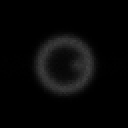

In [ ]:
colorview(Gray, img_n[:, :, 32])

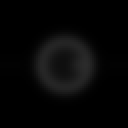

In [ ]:
colorview(Gray, res2[:, :, 32])

In [ ]:
@benchmark richardson_lucy_iterative(img_n, psf, regularizer=reg, iterations=30)  samples=100 evals=1

BenchmarkTools.Trial: 27 samples with 1 evaluation.
 Range (min … max):  135.740 ms … 204.460 ms  ┊ GC (min … max): 4.07% … 1.87%
 Time  (median):     160.517 ms               ┊ GC (median):    3.46%
 Time  (mean ± σ):   162.710 ms ±  18.983 ms  ┊ GC (mean ± σ):  3.80% ± 2.73%

  ▃    █       ▃       ▃     ▃                     ▃             
  █▇▁▁▁█▁▁▁▁▁▁▇█▇▁▁▁▁▇▇█▁▁▇▇▁█▇▁▁▇▁▁▇▇▁▁▁▁▁▁▁▁▁▁▇▁▁█▇▁▁▁▁▁▁▁▁▁▇ ▁
  136 ms           Histogram: frequency by time          204 ms <

 Memory estimate: 38.15 MiB, allocs estimate: 1894.

In [ ]:
res = richardson_lucy_iterative(img_n, psf, regularizer=nothing, iterations=30);

println(size(res))
println("res element type: ", eltype(res))

(64, 64, 64)
res element type: Float32


In [ ]:
@benchmark richardson_lucy_iterative(img_n, psf, regularizer=nothing, iterations=30) samples=100 evals=1 seconds=60

BenchmarkTools.Trial: 100 samples with 1 evaluation.
 Range (min … max):  40.145 ms … 127.341 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     53.910 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   58.477 ms ±  15.067 ms  ┊ GC (mean ± σ):  1.87% ± 4.09%

  ▂ ▂    ▆ ▄ █  ▆            ▂                                  
  ███▆▄▆██▄███▆███▁█▄▆█▆▄▆▆█▁█▁▁▁▁▄▄▆█▆▁▆▁▆▁▁▁▁▆▆▁▁▁▁▁▁▄▄▄▁▁▁▄ ▄
  40.1 ms         Histogram: frequency by time         96.2 ms <

 Memory estimate: 7.10 MiB, allocs estimate: 33.

In [ ]:
# Verificar valores mínimos y máximos en las matrices resultantes
println("Max value in res2: ", maximum(res2))
println("Min value in res2: ", minimum(res2))
println("Max value in res: ", maximum(res))
println("Min value in res: ", minimum(res))
println("Max value in img_n: ", maximum(img_n))
println("Min value in img_n: ", minimum(img_n))


Max value in res2: 0.41453165
Min value in res2: -0.0
Max value in res: 0.5674034
Min value in res: 0.0
Max value in img_n: 0.2627451
Min value in img_n: 0.0


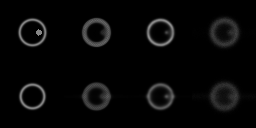

In [ ]:
img_comb1 = [img[:, : ,32] res2[:, :, 32] res[:, :, 32] img_n[:, :, 32]]
img_comb2 = [img[:, : ,38] res2[:, :, 38] res[:, :, 38] img_n[:, :, 38]]

img_comb = cat(img_comb1, img_comb2, dims=1)
#img_comb ./= maximum(img_comb)

#imshow([img[:, :, 20:end] res2[:, :, 20:end] res[:, :, 20:end] img_n[:, :, 20:end]])
colorview(Gray, img_comb)

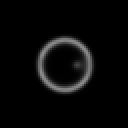

In [ ]:
colorview(Gray, res[:, :, 32])

In [ ]:
imshow(res[:, :, 32])

Dict{String, Any} with 4 entries:
  "gui"         => Dict{String, Any}("window"=>GtkWindowLeaf(Ptr{GObject} @0x00…
  "roi"         => Dict{String, Any}("redraw"=>ObserverFunction[ObserverFunctio…
  "annotations" => Observable(Dict{UInt64, Any}())
  "clim"        => Observable(CLim{Float32}(0.0, 0.556572))

---
## Cell 3D

In [ ]:
cell = convert(Array{Float32}, channelview(load("cells3d_convolved.tiff")));

Loading: 100%|███████████████████████████████████████████| Time: 0:00:00


In [ ]:
cell_psf = convert(Array{Float32}, channelview(load("cells3d_psf.tiff")));

In [ ]:
cell = cell .- minimum(cell) 
cell /= (maximum(cell) - minimum(cell));
cell_psf /= maximum(cell_psf);

In [ ]:
# imshow(cell[:,:,30])

In [ ]:
# colorview(Gray,cell[:,:,30])

In [ ]:
# colorview(Gray,cell[:,:,30]/maximum(cell[:,:,30]))

In [ ]:
cell2 = cell .- minimum(cell) 
cell2 /= (maximum(cell) - minimum(cell));
cell_psf2 = cell_psf .- minimum(cell_psf) 
cell_psf2 /= (maximum(cell_psf) - minimum(cell_psf));

In [ ]:
# colorview(Gray,cell2[:,:,30])

In [ ]:
# colorview(Gray, cell_psf[:,:,30])

In [ ]:
# colorview(Gray, cell_psf2[:,:,30])

In [ ]:
i_cell_psf = ifftshift(cell_psf2);

In [ ]:
@btime richardson_lucy_iterative(cell2, i_cell_psf, regularizer=nothing, iterations=30);

  172.630 ms (33 allocations: 7.99 MiB)


In [ ]:
# colorview(Gray, cell_res2[:,:,30])

In [ ]:
# imshow(cell_res[:,:,30])

In [ ]:
@benchmark richardson_lucy_iterative(cell2, i_cell_psf, regularizer=nothing, iterations=30) samples=10 evals=1 seconds=60

BenchmarkTools.Trial: 10 samples with 1 evaluation.
 Range (min … max):  173.518 ms … 184.871 ms  ┊ GC (min … max): 0.00% … 5.15%
 Time  (median):     175.553 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   177.349 ms ±   3.889 ms  ┊ GC (mean ± σ):  0.54% ± 1.63%

  █ █     ████            █  █                        █       █  
  █▁█▁▁▁▁▁████▁▁▁▁▁▁▁▁▁▁▁▁█▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁█ ▁
  174 ms           Histogram: frequency by time          185 ms <

 Memory estimate: 7.99 MiB, allocs estimate: 33.

---
## Cube of Spherical Beads

In [ ]:
# Cargamos la imagen

cube = convert(Array{Float32}, channelview(load("cubeConvolved.tif")));

# Cargamos la psf

cubePSF = convert(Array{Float32}, channelview(load("PSF.tif")));

cube2 = cube .- minimum(cube)
cube2 /= (maximum(cube) - minimum(cube));
cubePSF /= maximum(cubePSF);
cubePSF2 = cubePSF .- minimum(cubePSF)
cubePSF2 /= (maximum(cubePSF) - minimum(cubePSF));


Loading: 100%|███████████████████████████████████████████| Time: 0:00:00


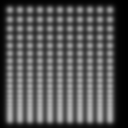

In [ ]:
colorview(Gray, cube2[:,:,30])

In [ ]:
number_of_iterations = 30

30

In [ ]:
deconCube = richardson_lucy_iterative(cube2, ifftshift(cubePSF2), regularizer=nothing, iterations=number_of_iterations);

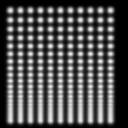

In [ ]:
colorview(Gray, deconCube[:,:,30])

In [ ]:
@benchmark richardson_lucy_iterative(cube, ifftshift(cubePSF), regularizer=nothing, iterations=number_of_iterations) samples=10 evals=1

BenchmarkTools.Trial: 8 samples with 1 evaluation.
 Range (min … max):  536.081 ms … 620.943 ms  ┊ GC (min … max): 0.89% … 0.94%
 Time  (median):     546.064 ms               ┊ GC (median):    1.00%
 Time  (mean ± σ):   555.845 ms ±  28.991 ms  ┊ GC (mean ± σ):  1.20% ± 0.74%

  █          ▃                                                   
  █▁▁▇▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▇▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▇ ▁
  536 ms           Histogram: frequency by time          621 ms <

 Memory estimate: 64.38 MiB, allocs estimate: 37.

---
## C. elegans embryo

In [ ]:
import Pkg;

Pkg.add("FileIO")

   Resolving package versions...
  No Changes to `C:\Users\biagi\Documents\Julia-projects\TFGNotebook\Project.toml`
  No Changes to `C:\Users\biagi\Documents\Julia-projects\TFGNotebook\Manifest.toml`


In [ ]:
using FileIO
using Images

function load_image_stack(folder_path::String)
    # Listar todos los archivos en la carpeta y ordenar
    files = sort(filter(f -> endswith(f, ".tif") || endswith(f, ".png") || endswith(f, ".jpg"), readdir(folder_path)))

    # Leer la primera imagen para obtener las dimensiones
    first_image = load(joinpath(folder_path, files[1]))
    height, width = size(first_image)

    # Crear una matriz 3D vacía para almacenar las imágenes
    image_stack = Array{Float32, 3}(undef, length(files), height, width)

    # Cargar cada imagen en la matriz 3D y convertir a Float32
    for (i, file) in enumerate(files)
        image = load(joinpath(folder_path, file))
        image_stack[i, :, :] = float(image)
    end

    return image_stack
end


load_image_stack (generic function with 1 method)

In [ ]:
function normalize_img(img)
    img2 = img .- minimum(img)
    img2 /= (maximum(img) .- minimum(img))
end

normalize_img (generic function with 1 method)

### Canal 1

In [ ]:
# Ruta a la carpeta que contiene las imágenes Z-stack
imagePath = "./CElegans-CY3"
psfPath = "./PSF-CElegans-CY3"

# Cargar las imágenes en una matriz 3D
image_stack = load_image_stack(imagePath)[:, 1:356, 1:336]
psf_stack = load_image_stack(psfPath)[:, 179:534, 169:504] #mitad +152

# Verificar las dimensiones de las matrices 3D
println(size(image_stack))
println("image_stack element type: ", eltype(image_stack))
println(size(psf_stack))


(104, 356, 336)
image_stack element type: Float32
(104, 356, 336)


In [ ]:
image_stack1n = normalize_img(image_stack)
psf_stack1n = normalize_img(psf_stack);

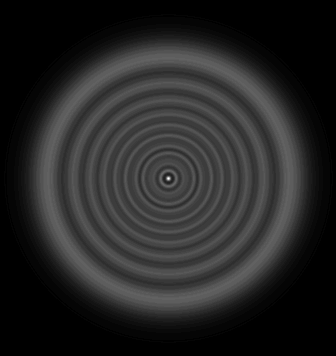

In [ ]:
colorview(Gray, psf_stack1n[1,:,:]/maximum(psf_stack1n[1,:,:]))


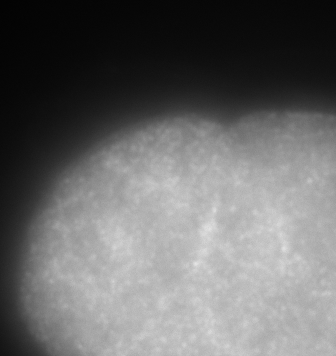

In [ ]:
colorview(Gray, image_stack1n[52,:,:])

In [ ]:
num_iter = 75

canal1_res = richardson_lucy_iterative(image_stack1n, ifftshift(psf_stack1n), regularizer=nothing, iterations=num_iter);


In [ ]:
# Verificar las dimensiones y tipo de canal1_res
println("Tipo de canal1_res: ", typeof(canal1_res))
println("Dimensiones de canal1_res: ", size(canal1_res))


Tipo de canal1_res: Array{Float32, 3}
Dimensiones de canal1_res: (104, 356, 336)


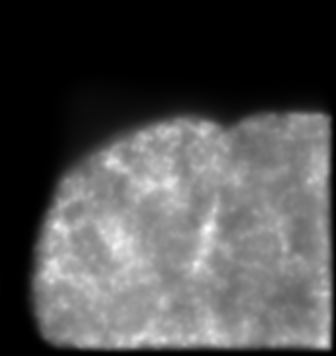

In [ ]:
colorview(Gray, canal1_res[52,:,:]/maximum(canal1_res[52,:,:]))

In [ ]:
@benchmark richardson_lucy_iterative(image_stack1n, ifftshift(psf_stack1n), regularizer=nothing, iterations=1) samples=10

BenchmarkTools.Trial: 10 samples with 1 evaluation.
 Range (min … max):  350.093 ms … 761.028 ms  ┊ GC (min … max):  0.00% … 51.54%
 Time  (median):     385.807 ms               ┊ GC (median):     9.78%
 Time  (mean ± σ):   459.491 ms ± 159.736 ms  ┊ GC (mean ± σ):  22.36% ± 20.00%

  █▁▁ ▁ ▁     ▁ ▁                                            ▁▁  
  ███▁█▁█▁▁▁▁▁█▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁██ ▁
  350 ms           Histogram: frequency by time          761 ms <

 Memory estimate: 382.38 MiB, allocs estimate: 35.

### Canal 2

In [ ]:
# Ruta a la carpeta que contiene las imágenes Z-stack
imagePath2 = "./CElegans-DAPI"
psfPath2 = "./PSF-CElegans-DAPI"

# Cargar las imágenes en una matriz 3D
image_stack2 = load_image_stack(imagePath2)[:, 1:356, 1:336]
psf_stack2 = load_image_stack(psfPath2)[:, 179:534, 169:504] #mitad +152

# Verificar las dimensiones de las matrices 3D
println(size(image_stack2))
println("image_stack element type: ", eltype(image_stack2))
println(size(psf_stack2))

(104, 356, 336)
image_stack element type: Float32
(104, 356, 336)


In [ ]:
image_stack2n = normalize_img(image_stack2)
psf_stack2n = normalize_img(psf_stack2);

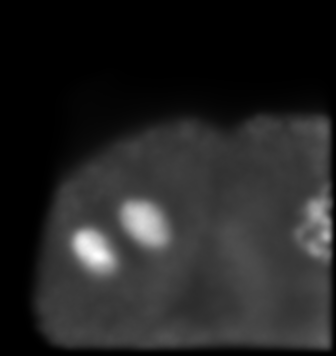

In [ ]:
canal2_res = richardson_lucy_iterative(image_stack2n, ifftshift(psf_stack2n), regularizer=nothing, iterations=num_iter);

colorview(Gray, canal2_res[52,:,:]/maximum(canal2_res[52,:,:]))

### Canal 3

In [ ]:
# Ruta a la carpeta que contiene las imágenes Z-stack
imagePath3 = "./CElegans-FITC"
psfPath3 = "./PSF-CElegans-FITC"

# Cargar las imágenes en una matriz 3D
image_stack3 = load_image_stack(imagePath3)[:, 1:356, 1:336]
psf_stack3 = load_image_stack(psfPath3)[:, 179:534, 169:504] #mitad +152

# Verificar las dimensiones de las matrices 3D
println(size(image_stack3))
println("image_stack element type: ", eltype(image_stack3))
println(size(psf_stack3))

(104, 356, 336)
image_stack element type: Float32
(104, 356, 336)


In [ ]:
image_stack3n = normalize_img(image_stack3)
psf_stack3n = normalize_img(psf_stack3);

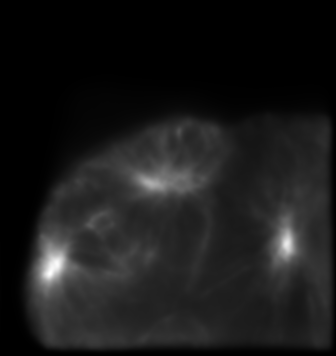

In [ ]:
canal3_res = richardson_lucy_iterative(image_stack3n, ifftshift(psf_stack3n), regularizer=nothing, iterations=num_iter);

colorview(Gray, canal3_res[52,:,:]/maximum(canal3_res[52,:,:]))

In [ ]:
imshow(canal3_res[52,:,:])

Dict{String, Any} with 4 entries:
  "gui"         => Dict{String, Any}("window"=>GtkWindowLeaf(Ptr{GObject} @0x00…
  "roi"         => Dict{String, Any}("redraw"=>ObserverFunction[ObserverFunctio…
  "annotations" => Observable(Dict{UInt64, Any}())
  "clim"        => Observable(CLim{Float32}(9.15681f-15, 3.68774))

### Combinación de canales

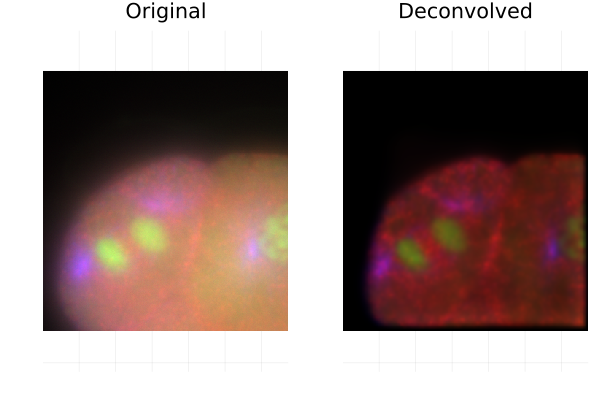

In [ ]:
using Plots
using Images
using ColorTypes

# Función para normalizar una imagen
function normalize(image::AbstractArray)
    min_val = minimum(image)
    max_val = maximum(image)
    if min_val == max_val
        return zeros(size(image))  # O ones(size(image)), dependiendo de tu preferencia
    end
    return (image .- min_val) ./ (max_val - min_val)
end

# Normalizar los canales
deconvolved_stack_R = normalize(canal1_res)
deconvolved_stack_G = normalize(canal2_res)
deconvolved_stack_B = normalize(canal3_res)

# Crear una imagen RGB para la visualización
function create_rgb_image(r::AbstractArray, g::AbstractArray, b::AbstractArray)
    # Verificar que todas las dimensiones sean iguales
    height, width = size(r)
    if size(g) != (height, width) || size(b) != (height, width)
        throw(ArgumentError("Las dimensiones de las imágenes R, G y B deben coincidir."))
    end

    # Crear una matriz de imágenes RGB
    rgb_image = Array{RGB{Float32}, 2}(undef, height, width)
    rgb_image[:, :] .= RGB{Float32}[RGB(r[i, j], g[i, j], b[i, j]) for i in 1:height, j in 1:width]
    return rgb_image
end

# Combinar los canales en una imagen RGB
deconvolved_image_color = create_rgb_image(deconvolved_stack_R[52, :, :],
                                           deconvolved_stack_G[52, :, :],
                                           deconvolved_stack_B[52, :, :])

# Normalizar y combinar los planos para la visualización
original_image_rgb = create_rgb_image(normalize(image_stack[52, :, :]),
                                       normalize(image_stack2[52, :, :]),
                                       normalize(image_stack3[52, :, :]))

# Mostrar las imágenes
plot(
    heatmap(original_image_rgb, title="Original", axis=false, color=:viridis),
    heatmap(deconvolved_image_color, title="Deconvolved", axis=false, color=:viridis),
    layout=(1, 2)
)


